<a href="https://colab.research.google.com/github/tarikoztas/Istanbul-Trafik-Davranis-Kaliplari-Analizi/blob/main/%C4%B0stanbul_trafik_davran%C4%B1%C5%9F_kal%C4%B1plar%C4%B1n%C4%B1n_analizi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import folium
from folium.plugins import MarkerCluster
import plotly.express as px

In [ ]:
df = pd.read_csv('traffic_density_202501.csv', nrows=100000)
df.head()

df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])
df['HOUR'] = df['DATE_TIME'].dt.hour
df['DAY_OF_WEEK'] = df['DATE_TIME'].dt.dayofweek
df['IS_WEEKEND'] = df['DAY_OF_WEEK'].isin([5,6]).astype(int)

features = df[['LATITUDE', 'LONGITUDE', 'AVERAGE_SPEED', 'NUMBER_OF_VEHICLES', 'HOUR', 'IS_WEEKEND']]

# Handle NaN values by filling with the mean of each column
features = features.fillna(features.mean())

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

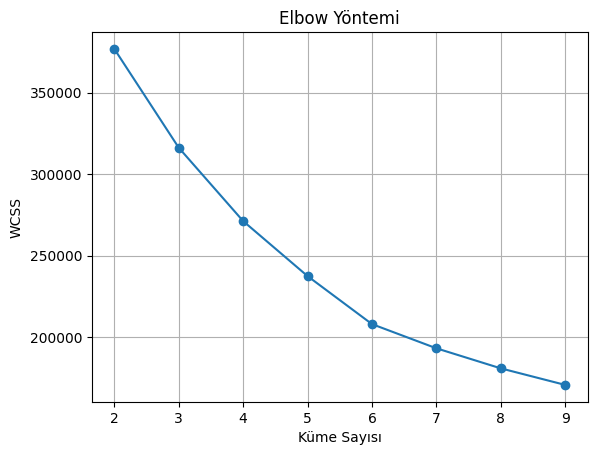

In [ ]:
# Elbow yöntemi
wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 10), wcss, marker='o')
plt.title("Elbow Yöntemi")
plt.xlabel("Küme Sayısı")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

In [ ]:
#bu aşama biraz zaman alabilir

from sklearn.utils import resample
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sample_data = resample(scaled_features, n_samples=100000, random_state=42)
print("Silhouette skorları:\n")
for i in range(2, 7):
    try:
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        labels = kmeans.fit_predict(sample_data)
        unique_labels = set(labels)
        if len(unique_labels) < 2:
            print(f"{i} küme için: Yetersiz farklı küme (sadece {len(unique_labels)} küme).")
            continue
        score = silhouette_score(sample_data, labels)
        print(f"{i} küme için silhouette skoru: {score:.4f}")
    except Exception as e:
        print(f"{i} küme için hata: {e}")

Silhouette skorları:



In [ ]:
# K-means kümeleme
kmeans = KMeans(n_clusters=4, random_state=42)
df['CLUSTER'] = kmeans.fit_predict(scaled_features)

# PCA ile 2 boyuta indirgeme
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['CLUSTER'] = df['CLUSTER'].values

# Renk haritası (0: Mor, 1: Kırmızı, 2: Mavi, 3: Yeşil)
custom_colors = {
    '0': 'purple',
    '1': 'red',
    '2': 'blue',
    '3': 'green'
}

pca_df['CLUSTER_STR'] = pca_df['CLUSTER'].astype(str)

fig = px.scatter(
    pca_df, x='PCA1', y='PCA2', color='CLUSTER_STR',
    title='PCA ile Trafik Kümeleri (Renkli)',
    color_discrete_map=custom_colors,
    labels={'CLUSTER_STR': 'Küme'},
    opacity=0.7
)
fig.show()

In [ ]:
# Harita
map_istanbul = folium.Map(location=[41.01, 28.97], zoom_start=10)
marker_cluster = MarkerCluster().add_to(map_istanbul)

for i in range(len(df)):
    lat = df.iloc[i]['LATITUDE']
    lon = df.iloc[i]['LONGITUDE']
    cluster = df.iloc[i]['CLUSTER']
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        popup=f'Küme: {cluster}',
        color=['red', 'green', 'blue'][cluster % 3],  # 3 küme için renk
        fill=True,
        fill_opacity=0.6
    ).add_to(marker_cluster)

map_istanbul


Buffered data was truncated after reaching the output size limit.